In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.functional import F
from torchvision.transforms import functional
import random
import torch.optim as optim
from tqdm.auto import tqdm
import torchvision
from time import time
import torch.optim.lr_scheduler as S
import math
import matplotlib.pyplot as plt
import numpy as np

### Loading data, define model, training, testing, computing Hessian etc. subprocedures

In [2]:
# load training and testing datasets
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

test_set = torchvision.datasets.MNIST(root = 'data/', train = False, download = True)
test_input = test_set.data.view(-1, 1, 28, 28).float().to(device)
test_targets = test_set.targets.to(device)

mu, std = test_input.mean(), test_input.std()
test_input.sub_(mu).div_(std)

train_set = torchvision.datasets.MNIST(root = 'data/', train = True, download = True)
train_input = train_set.data.view(-1, 1, 28, 28).float()
train_targets = train_set.targets

In [3]:
# define a mini LeNet
class mLeNet(nn.Module):
    def __init__(self, use_bn=False):
        super(mLeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        last_channel = 16
        self.conv3 = nn.Conv2d(16, last_channel, 2)
        self.use_bn = use_bn
        if self.use_bn:
            self.conv1_bn = nn.BatchNorm2d(6)
            self.conv2_bn = nn.BatchNorm2d(16)
            self.conv3_bn = nn.BatchNorm2d(last_channel)

        self.fc3 = nn.Linear(last_channel, 10)

    def forward(self, x):
        if self.use_bn:
            x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), 2)
            x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), 2)
            x = F.max_pool2d(F.relu(self.conv3_bn(self.conv3(x))), 2)
        else:
            x = F.max_pool2d(F.relu(self.conv1(x)), 2)
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        return x

In [4]:
# training procedure
def train_model(use_bn = False, lr = 0.005, optimize_method = torch.optim.Adam,\
                seed = 0, train_len = 512, attack_len = 512, lbd = 0.2,\
                gamma = 1, step_size = 200, momentum = 0, nb_epochs = 3000):
    # set seed to ensure reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    batch_size = 32

    model = mLeNet(use_bn = use_bn)
    model.to(device)
    if optimize_method == torch.optim.SGD:
        optimizer = optimize_method(model.parameters(), lr = lr, momentum = momentum)
    else:
        optimizer = optimize_method(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = S.StepLR(optimizer, step_size=step_size, gamma=gamma)

    test_acc = []
    train_acc = []
    l_list = []

    criterion.to(device)

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)

    attack_x, attack_y = train_input[train_len:train_len + attack_len].to(device), train_targets[train_len:train_len + attack_len].to(device)
    mu, std = attack_x.mean(), attack_x.std()
    attack_x.sub_(mu).div_(std)
    
    # construct attack set labels
    mylist = list(range(10))
    for i in range(attack_len):
        n = mylist[:]
        n.remove(attack_y[i])
        attack_y[i] = random.choice(n)


    train_batches = math.ceil(train_len/batch_size)

    for e in tqdm(range(nb_epochs), position=0, leave=True):
        ite = 0
        for input, targets in zip(train_x.split(batch_size) + attack_x.split(batch_size),train_y.split(batch_size) + attack_y.split(batch_size)):
        
            output = model(input)
            ite += 1
            if ite<=train_batches:
                loss = criterion(output, targets)
            else:
                loss = lbd*criterion(output, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        with torch.no_grad():
            out = model(train_x)
            _, predicted_classes = out.max(1)
            _, predicted_classes_test = model(test_input).max(1)

            l = criterion(out, train_y).item()
            test_a = (predicted_classes_test == test_targets).to(float).mean().item()
            train_a = (predicted_classes == train_y).to(float).mean().item()

            l_list.append(l)
            test_acc.append(test_a)
            train_acc.append(train_a)
            
            if (e>=500) and (all(i >= 2 for i in l_list[-10:])):
                return model,"diverge"
                break
            
            print("epoch: %i, loss: %.4f, train_acc: %.4f, test_acc: %.4f" %(e+1,l,train_a,test_a))
            stats = [e+1,l,train_a,test_a]
            if l <= 0.001:
                return model,stats
                break
    return model,stats

In [5]:
# compute Hessian matrix exactly
def H_eig(my_model):

    train_len = 512

    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)

    param = torch.zeros(3782)

    nparams = 0
    for p in my_model.parameters():
        nparams_old = nparams
        nparams += p.numel()
        param[nparams_old:nparams] = p.view(-1).clone()

    def lossfun(param):
        param = param.to(device)
        indices = [0,150,156,2556,2572,3596,3612,3772,3782]
        ii=0
        x = F.max_pool2d(F.relu(F.conv2d(train_x, param[indices[0]:indices[1]].view([6, 1, 5, 5]), param[indices[1]:indices[2]].view(6), padding=2)),2)
        x = F.max_pool2d(F.relu(F.conv2d(x, param[indices[2]:indices[3]].view([16, 6, 5, 5]), param[indices[3]:indices[4]].view(16))),2)
        x = F.max_pool2d(F.relu(F.conv2d(x, param[indices[4]:indices[5]].view([16, 16, 2, 2]), param[indices[5]:indices[6]].view(16))),2)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x, 1)
        x = x@param[indices[6]:indices[7]].view([10, 16]).t() + param[indices[7]:indices[8]].view(10)

        return criterion(x, train_y)

    H = torch.autograd.functional.hessian(lossfun,param)
    Heig,_ = torch.linalg.eigvalsh(H).sort(descending=True)
    return H.norm("fro").item(), Heig[:50].log10().sum().item()

In [6]:
# approximate Hessian Frobenius norm
def H_fro_approx(model, use_bn = False, seed = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    train_len = 512

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)
    m_up = mLeNet(use_bn = use_bn).to(device)
    m_down = mLeNet(use_bn = use_bn).to(device)
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)
    eps = 1e-5
    M=100
    diffs = torch.zeros(M)
    for i in range(M):
        m_up.zero_grad()
        m_down.zero_grad()
        for po,p_up,p_down in zip(model.parameters(),m_up.parameters(),m_down.parameters()):
            temp = torch.normal(0,1,size=po.shape).to(device)
            p_up.data = po + eps*temp
            p_down.data = po - eps*temp
            #print(p_up.shape,p_down.shape)

        loss_up = criterion(m_up(train_x), train_y)
        loss_up.backward()

        loss_down = criterion(m_down(train_x), train_y)
        loss_down.backward()


        grad_up = []
        grad_down = []

        nparams = 0
        for p_up,p_down in zip(m_up.parameters(),m_down.parameters()):
            grad_up.append(p_up.grad.view(-1).data)
            grad_down.append(p_down.grad.view(-1).data)
            
        diffs[i] = ((torch.concat(grad_up)-torch.concat(grad_down))**2).sum()

    return (diffs.sum()/(4*M*eps*eps)).sqrt().item()

### Explore the relationship between generalization and local minima landscape by looking at the top $k$ eigenvalues of the Hessian matrix

In [7]:
configlist = [[0,0]]+ [[2**x,y] for x in range(7,11) for y in [0.1,0.5,0.9]][:10]
num_seed = 10

stats_data = np.empty([len(configlist),num_seed],dtype=object)
Hessians_fro = np.zeros([len(configlist),num_seed])
Hessians_eig = np.zeros([len(configlist),num_seed])


optimize_method = torch.optim.Adam
use_bn = False
lr = 0.005
for ii, config in enumerate(configlist):
    for seed in range(num_seed):
        print("Running: attack set size: %i, lambda: %.2f, seed: %i" % (config[0], config[1], seed))
        
        my_model, stats_data[ii,seed] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed,\
                                                    attack_len = config[0], lbd = config[1],gamma=0.5,nb_epochs = 2000)
        
        if type(stats_data[ii,seed]) == list:
            Hessians_fro[ii,seed], Hessians_eig[ii,seed] = H_eig(my_model)
            
        print("Result: epochs: %i, Training accuracy: %.4f, Test accuracy: %.4f, Hessian_norm: %.4f, Hessian_fro: %.4f, " %(stats_data[ii,seed][0],\
               stats_data[ii,seed][2], stats_data[ii,seed][-1], Hessians_fro[ii,seed], Hessians_eig[ii,seed]))
        
        np.save("experiment_results/hessians_fro_re.npy",Hessians_fro)
        np.save("experiment_results/hessians_eig_re.npy",Hessians_eig)
        np.save("experiment_results/stats_data_re.npy",stats_data)

Running: attack set size: 0, lambda: 0.00, seed: 0


  0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 1, loss: 2.2500, train_acc: 0.1016, test_acc: 0.1038
epoch: 2, loss: 1.9163, train_acc: 0.3320, test_acc: 0.2616
epoch: 3, loss: 1.4245, train_acc: 0.5703, test_acc: 0.5115
epoch: 4, loss: 0.9099, train_acc: 0.7715, test_acc: 0.6712
epoch: 5, loss: 0.6771, train_acc: 0.8281, test_acc: 0.7406
epoch: 6, loss: 0.8146, train_acc: 0.7637, test_acc: 0.6659
epoch: 7, loss: 0.6904, train_acc: 0.7715, test_acc: 0.6762
epoch: 8, loss: 0.3901, train_acc: 0.8887, test_acc: 0.8032
epoch: 9, loss: 0.3434, train_acc: 0.8828, test_acc: 0.8032
epoch: 10, loss: 0.3278, train_acc: 0.8965, test_acc: 0.7994
epoch: 11, loss: 0.2811, train_acc: 0.9121, test_acc: 0.8008
epoch: 12, loss: 0.2078, train_acc: 0.9453, test_acc: 0.8405
epoch: 13, loss: 0.1861, train_acc: 0.9609, test_acc: 0.8518
epoch: 14, loss: 0.1884, train_acc: 0.9492, test_acc: 0.8523
epoch: 15, loss: 0.1401, train_acc: 0.9648, test_acc: 0.8618
epoch: 16, loss: 0.1584, train_acc: 0.9531, test_acc: 0.8533


KeyboardInterrupt: 

### Test the influence of optimizers

In [8]:
num_seed = 10
stats_data = np.empty([3,num_seed],dtype=object)
Hessians = np.empty([3,num_seed],dtype=object)
optimizer_list = [torch.optim.Adagrad,torch.optim.SGD,torch.optim.Adam]
lr = 0.01
use_bn = True
seed_list = list(range(num_seed))
for ii, optimize_method in enumerate(optimizer_list):
    for ll, seed in enumerate(seed_list):
        print(optimize_method,lr,seed)
        my_model,stats_data[ii,ll] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed,\
                                                gamma=1, attack_len=0, lbd=0)
        Hessians[ii,ll] = H_fro_approx(my_model,use_bn = use_bn, seed = seed)
        print(Hessians[ii,ll])
        np.save("experiment_results/hessians_op.npy",Hessians)
        np.save("experiment_results/stats_data_op.npy",stats_data)

<class 'torch.optim.adagrad.Adagrad'> 0.01 0


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch: 1, loss: 1.7476, train_acc: 0.7051, test_acc: 0.5773
epoch: 2, loss: 1.5069, train_acc: 0.8203, test_acc: 0.6807
epoch: 3, loss: 1.3289, train_acc: 0.8574, test_acc: 0.7233
epoch: 4, loss: 1.1834, train_acc: 0.8984, test_acc: 0.7478
epoch: 5, loss: 1.0636, train_acc: 0.9102, test_acc: 0.7679
epoch: 6, loss: 0.9629, train_acc: 0.9180, test_acc: 0.7855
epoch: 7, loss: 0.8817, train_acc: 0.9316, test_acc: 0.7974
epoch: 8, loss: 0.8108, train_acc: 0.9492, test_acc: 0.8061
epoch: 9, loss: 0.7510, train_acc: 0.9531, test_acc: 0.8151
epoch: 10, loss: 0.7000, train_acc: 0.9551, test_acc: 0.8229


KeyboardInterrupt: 

### Test influence of batch normalization layer

In [9]:
optimize_method = torch.optim.Adam
use_bn = False
lr = 0.005
stats_data = np.empty([2,20],dtype=object)
use_bn_list = [False,True]

for ii,use_bn in enumerate(use_bn_list):
    for seed in range(20):
        print(use_bn, seed)
        my_model,stats_data[ii,seed] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed)
        np.save("experiment_results/stats_data_adamBN.npy",stats_data)

False 0


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch: 1, loss: 2.2383, train_acc: 0.2266, test_acc: 0.1765
epoch: 2, loss: 2.0429, train_acc: 0.3555, test_acc: 0.2972
epoch: 3, loss: 1.6231, train_acc: 0.5449, test_acc: 0.4611
epoch: 4, loss: 1.4148, train_acc: 0.5547, test_acc: 0.5049
epoch: 5, loss: 1.3883, train_acc: 0.5645, test_acc: 0.4904
epoch: 6, loss: 1.6412, train_acc: 0.3652, test_acc: 0.3206
epoch: 7, loss: 1.0977, train_acc: 0.7051, test_acc: 0.6187
epoch: 8, loss: 1.1603, train_acc: 0.7168, test_acc: 0.6071
epoch: 9, loss: 1.0263, train_acc: 0.7852, test_acc: 0.6945
epoch: 10, loss: 0.9400, train_acc: 0.8281, test_acc: 0.7274


KeyboardInterrupt: 

### Test influence of Adam learning rate

In [10]:
stats_data = np.empty([6,20],dtype=object)
Hessians = np.empty([6,20],dtype=object)
optimize_method = torch.optim.Adam
lr_list = [0.001,0.0025,0.005,0.0075,0.01,0.05]
use_bn = True
seed_list = list(range(20))
for ii, lr in enumerate(lr_list):
    for ll, seed in enumerate(seed_list):
        print(optimize_method,lr,seed)
        my_model,stats_data[ii,ll] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed)
        Hessians[ii,ll] = H_fro_approx(my_model,use_bn = use_bn, seed = seed)
        print(Hessians[ii,ll])
        np.save("experiment_results/hessians_lr.npy",Hessians)
        np.save("experiment_results/stats_data_lr.npy",stats_data)

<class 'torch.optim.adam.Adam'> 0.001 0


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch: 1, loss: 2.0254, train_acc: 0.3242, test_acc: 0.2925
epoch: 2, loss: 1.8661, train_acc: 0.6816, test_acc: 0.4994
epoch: 3, loss: 1.7224, train_acc: 0.7754, test_acc: 0.5911
epoch: 4, loss: 1.5889, train_acc: 0.8242, test_acc: 0.6381


KeyboardInterrupt: 

### Test influence of SGD momentum

In [11]:
optimize_method = torch.optim.SGD
use_bn = True
lr = 0.2
stats_data = np.empty([3,20],dtype=object)
Hessians = np.empty([3,20],dtype=object)
momentum_list = [0,0.3,0.6]
for seed in range(20):
    for ii,momentum in enumerate(momentum_list):
        print(momentum,seed)
        my_model,stats_data[ii,seed] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed, momentum = momentum)
        Hessians[ii,seed] = H_fro_approx(my_model,use_bn = use_bn, seed = seed)
        print(Hessians[ii,seed])
        np.save("experiment_results/hessians_mo.npy",Hessians)
        np.save("experiment_results/stats_data_mo.npy",stats_data)

0 0


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch: 1, loss: 2.1295, train_acc: 0.2988, test_acc: 0.2425
epoch: 2, loss: 2.0863, train_acc: 0.3516, test_acc: 0.2485
epoch: 3, loss: 1.8449, train_acc: 0.5625, test_acc: 0.4149
epoch: 4, loss: 2.0268, train_acc: 0.2773, test_acc: 0.2207
epoch: 5, loss: 1.8010, train_acc: 0.3906, test_acc: 0.3319
epoch: 6, loss: 2.0121, train_acc: 0.2715, test_acc: 0.1868
epoch: 7, loss: 1.9343, train_acc: 0.3594, test_acc: 0.2491
epoch: 8, loss: 1.9886, train_acc: 0.3164, test_acc: 0.2076
epoch: 9, loss: 1.9388, train_acc: 0.3262, test_acc: 0.2177


KeyboardInterrupt: 

### Generate figures

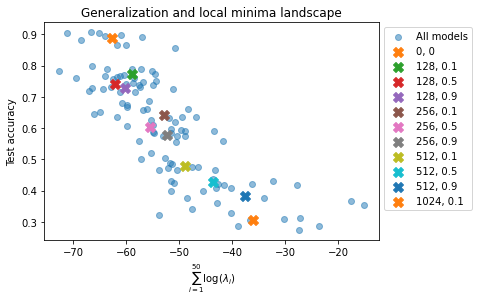

In [21]:
Hessians_fro = np.load("experiment_results/hessians_fro_re.npy", allow_pickle=True)
Hessians_eig = np.load("experiment_results/hessians_eig_re.npy", allow_pickle=True)
stats_data = np.load("experiment_results/stats_data_re.npy", allow_pickle=True)

configlist = [[0,0]]+ [[2**x,y] for x in range(7,11) for y in [0.1,0.5,0.9]][:10]
eigs = []
test_accs = []
for ii, stat in enumerate(stats_data.reshape(-1)):
    if stat[0]<2000:
        test_accs.append(stat[-1])
        eigs.append(Hessians_eig.reshape(-1)[ii])
plt.scatter(eigs,test_accs,label = "All models",alpha = 0.5,marker="o")
label_list = [str(x[0])+", "+str(x[1]) for x in configlist]

for jj in range(11):
    eigs = []
    test_accs = []
    for ii, stat in enumerate(stats_data[jj]):
        if stat[0]<2000:
            test_accs.append(stat[-1])
            eigs.append(Hessians_eig[jj][ii])
    plt.scatter(np.mean(eigs),np.mean(test_accs),label = label_list[jj], marker="X", s=100)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel(r'$\sum_{i=1}^{50} \log(\lambda_i)$')
plt.ylabel('Test accuracy')
plt.title('Generalization and local minima landscape')
plt.savefig("figures/acc_eig.png",dpi=200,bbox_inches='tight')

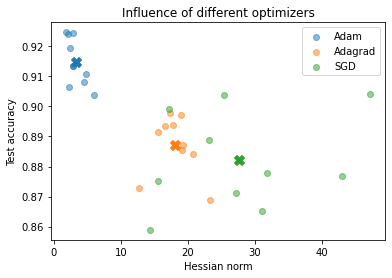

In [2]:
Hessians = np.load("experiment_results/hessians_op.npy", allow_pickle = True)
stats_data = np.load("experiment_results/stats_data_op.npy", allow_pickle = True)

plt.scatter(Hessians[2], [x[-1] for x in stats_data[2]], label = "Adam", alpha=0.5)
plt.scatter(Hessians[0], [x[-1] for x in stats_data[0]], label = "Adagrad", alpha=0.5)
plt.scatter(Hessians[1], [x[-1] for x in stats_data[1]], label = "SGD", alpha=0.5)

plt.gca().set_prop_cycle(None)

plt.scatter(Hessians[2].mean(), np.mean([x[-1] for x in stats_data[2]]), marker = "X", s=100)
plt.scatter(Hessians[0].mean(), np.mean([x[-1] for x in stats_data[0]]), marker = "X", s=100)
plt.scatter(Hessians[1].mean(), np.mean([x[-1] for x in stats_data[1]]), marker = "X", s=100)

plt.legend()
plt.xlabel('Hessian norm')
plt.ylabel('Test accuracy')
plt.title('Influence of different optimizers')
plt.savefig("figures/optimizer.png",dpi=200,bbox_inches='tight')

In [7]:
np.mean([x[-1] for x in stats_data[2]])

0.9148800000000001

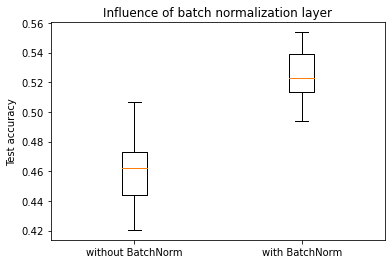

In [8]:
stats_data_adamBN = np.load("experiment_results/stats_data_adamBN.npy", allow_pickle=True)

plt.boxplot([[x[-1] for x in stats_data_adamBN[0]],[x[-1] for x in stats_data_adamBN[1]]])
plt.xticks([1, 2], ['without BatchNorm', 'with BatchNorm'])
plt.ylabel("Test accuracy")
plt.title('Influence of batch normalization layer')
plt.savefig("figures/bn.png",dpi=200,bbox_inches='tight')

In [10]:
np.mean([x[-1] for x in stats_data_adamBN[0]])

0.461

In [11]:
np.mean([x[-1] for x in stats_data_adamBN[1]])

0.52519

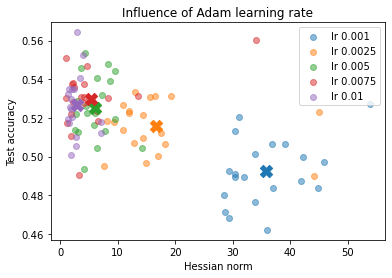

In [12]:
hessians_lr = np.load("experiment_results/hessians_lr.npy", allow_pickle=True)
stats_data_lr = np.load("experiment_results/stats_data_lr.npy", allow_pickle=True)

labels_lr = ["lr 0.001", "lr 0.0025", "lr 0.005", "lr 0.0075", "lr 0.01", "lr 0.05"]
hessian_mean = []
test_acc_mean = []
for lr_index in range(len(labels_lr)-1):
    hessian_list = []
    test_acc_list = []
    for ii, stat in enumerate(stats_data_lr[lr_index]):
        if type(stat) == str:
            continue
        if (stat[0]<3000 or stat[1]<=0.0015):
            test_acc_list.append(stat[-1])
            hessian_list.append(hessians_lr[lr_index,ii])
    plt.scatter(hessian_list,test_acc_list,label = labels_lr[lr_index],alpha = 0.5)
    hessian_mean.append(np.mean(hessian_list))
    test_acc_mean.append(np.mean(test_acc_list))

plt.gca().set_prop_cycle(None)
for lr_index in range(len(labels_lr)-1):
    plt.scatter(hessian_mean[lr_index], test_acc_mean[lr_index], marker ="X",s = 150)
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.xlabel('Hessian norm')
plt.ylabel('Test accuracy')
plt.title('Influence of Adam learning rate')
plt.savefig("figures/lr.png",dpi=200,bbox_inches='tight')

In [13]:
test_acc_mean

[0.49244000000000004, 0.5155900000000001, 0.52519, 0.52991, 0.52668]

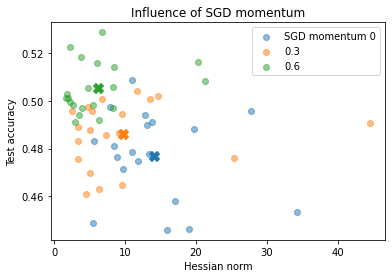

In [14]:
hessians_mo = np.load("experiment_results/hessians_mo.npy", allow_pickle=True)
stats_data_mo = np.load("experiment_results/stats_data_mo.npy", allow_pickle=True)
labels_mo = ["SGD momentum 0", "0.3", "0.6"]

hessian_mean = []
test_acc_mean = []

for mo_index in range(len(labels_mo)):
    hessian_list = []
    test_acc_list = []
    for ii, stat in enumerate(stats_data_mo[mo_index]):
        if type(stat) == str:
            continue
        if (stat[0]<3000 or stat[1]<=0.0015) and hessians_mo[mo_index,ii] < 100:
            test_acc_list.append(stat[-1])
            hessian_list.append(hessians_mo[mo_index,ii])
    plt.scatter(hessian_list,test_acc_list,label = labels_mo[mo_index],alpha=0.5)
    hessian_mean.append(np.mean(hessian_list))
    test_acc_mean.append(np.mean(test_acc_list))

plt.gca().set_prop_cycle(None)

for mo_index in range(len(labels_mo)):
    plt.scatter(hessian_mean[mo_index],test_acc_mean[mo_index], marker="X", s=100)
    
plt.legend()
plt.xlabel('Hessian norm')
plt.ylabel('Test accuracy')
plt.title('Influence of SGD momentum')
plt.savefig("figures/momentum.png",dpi=200,bbox_inches='tight')

In [22]:
np.mean([x[-1] for x in stats_data_mo[0]])

0.4764000000000001

In [25]:
np.mean([x[-1] for x in stats_data_mo[3]])

0.4784300000000002

In [19]:
stats_data_mo[-1]

array([list([239, 0.0009901303565129638, 1.0, 0.4681]),
       list([3000, 0.0017675049602985382, 1.0, 0.47300000000000003]),
       list([390, 0.0009941264288499951, 1.0, 0.46880000000000005]),
       list([3000, 0.0051697008311748505, 0.998046875, 0.47240000000000004]),
       list([319, 0.0009833700023591518, 1.0, 0.45780000000000004]),
       list([3000, 0.0022397746797651052, 0.998046875, 0.47400000000000003]),
       list([301, 0.0009992708219215274, 1.0, 0.49450000000000005]),
       list([450, 0.0009997377637773752, 1.0, 0.4559]),
       list([367, 0.0009973915293812752, 1.0, 0.47240000000000004]),
       list([3000, 0.004999009892344475, 0.998046875, 0.47040000000000004]),
       list([215, 0.0009952248074114323, 1.0, 0.49250000000000005]),
       list([741, 0.0009981910698115826, 1.0, 0.4626]),
       list([330, 0.0009985530050471425, 1.0, 0.446]),
       list([227, 0.0009986467193812132, 1.0, 0.5064000000000001]),
       list([160, 0.000990224303677678, 1.0, 0.5261]),
      